In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
ROI_ANNOTATION_CSV_PATH = "data/origin_data/anno_origin/new_roi.csv"
IMAGE_DIR = "data/ikeuchi_anno_data/sample_images"
IMAGE_WITH_ANN_DRAWING_DIR_PATH = "data/ikeuchi_anno_data/sample_annotated_images"

TARGET_IMAGE_NAME = "20211116_151936.jpg"

## Setting Parameters for leaf density estimation
# Extract leaf area
LCH_LOWER = [20.0, 0.0, 0.0]  # For bright area extraction
LCH_UPPER = [100.0, 120.0, 7.0]
HSV_LOWER = [35, 40, 50]  # For green area extraction
HSV_UPPER = [80, 255, 255]

# Visualize leaf density map as heat map
KERNEL_SIZE = 250
DENSITY_MIN = 80
NUM_DENSITY_BINS = 4
DIVIDED_AREA = [0, 30, 170, 240, 255]

# Discritize the image
GRID_SIZE = 6

# DECIDE_UNDERPOINT
#K_H_SIZE = 30
#SERCH_AREA = [2050, 3100]

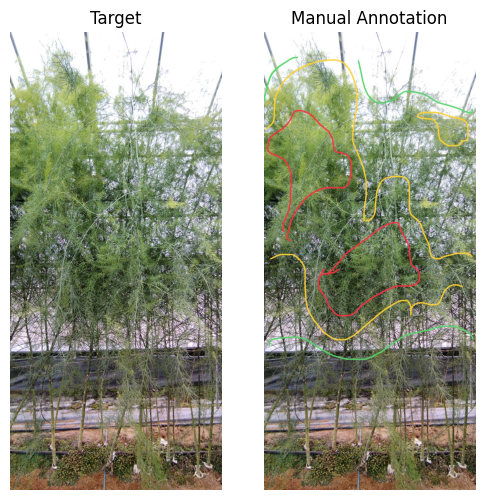

In [9]:
import cv2
from pathlib import Path
from scripts.utils import draw_multiple_image

image_pathlib = Path(IMAGE_DIR) / TARGET_IMAGE_NAME
assert image_pathlib.exists()

image_wi_ann_name = Path(TARGET_IMAGE_NAME).stem + "_anno.jpg"
image_wi_ann_pathlib = Path(IMAGE_WITH_ANN_DRAWING_DIR_PATH) / image_wi_ann_name
assert image_wi_ann_pathlib.exists()

target_image = cv2.imread(str(image_pathlib))
image_wi_ann = cv2.imread(str(image_wi_ann_pathlib))

# 処理対象画像と手動アノテーション画像を並べて表示
draw_multiple_image(["Target", "Manual Annotation"], [target_image, image_wi_ann], figsize=(6, 16))

## 有効領域情報の取得

In [10]:
import csv

map_image_name_to_horizontal_min_max = {}
with open(ROI_ANNOTATION_CSV_PATH) as csvfile:
    annotation_data_list = list(csv.reader(csvfile, delimiter=" ", quotechar="|"))
    for ann_data_icol in annotation_data_list:
        annotaion_info_str_list = ann_data_icol[0].split(",")
        if len(annotaion_info_str_list) == 4:
            image_name = annotaion_info_str_list[0]
            hmin, hmax = int(annotaion_info_str_list[1]), int(annotaion_info_str_list[2])
            map_image_name_to_horizontal_min_max[image_name] = hmin, hmax

assert map_image_name_to_horizontal_min_max.get(TARGET_IMAGE_NAME) is not None

print(f"有効領域の画像縦方向の範囲: {map_image_name_to_horizontal_min_max[TARGET_IMAGE_NAME]}")

有効領域の画像縦方向の範囲: (100, 2200)


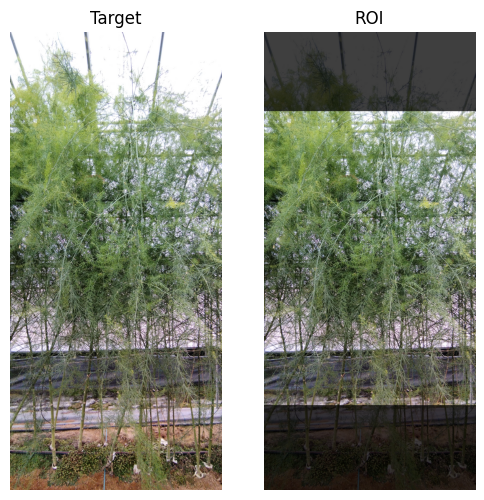

In [11]:
import numpy as np

image_roi_visualized = target_image.copy()
image_roi_visualized = np.clip(image_roi_visualized.astype(float) * 0.25, 0, 255).astype(np.uint8)
image_roi_visualized[hmin:hmax, :, :] = target_image[hmin:hmax, :, :]

draw_multiple_image(["Target", "ROI"], [target_image, image_roi_visualized], figsize=(6, 16))

## 画像をCIELab LCh色空間に変換

In [12]:
from matplotlib import pyplot as plt
from scripts.leaf_density_index import enhance_perception, extract_bright_area, rgb2lch

image_rgb = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
image_lch = rgb2lch(image_rgb)

bright_area_mask = extract_bright_area(enhance_perception(image_lch), LCH_LOWER, LCH_UPPER)
#plt.imshow(image_lch[:, :, 1])  # 彩度のみを表示

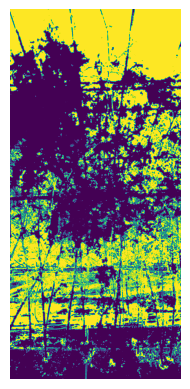

In [13]:
from scripts.utils import show_image_from_ndarray
show_image_from_ndarray(bright_area_mask)

### 緑色領域の抽出

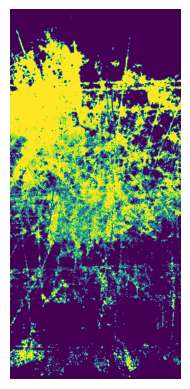

In [14]:
from scripts.leaf_density_index import extract_green_area

green_area_mask = extract_green_area(target_image, HSV_LOWER, HSV_UPPER)
show_image_from_ndarray(green_area_mask)

### 葉領域の抽出

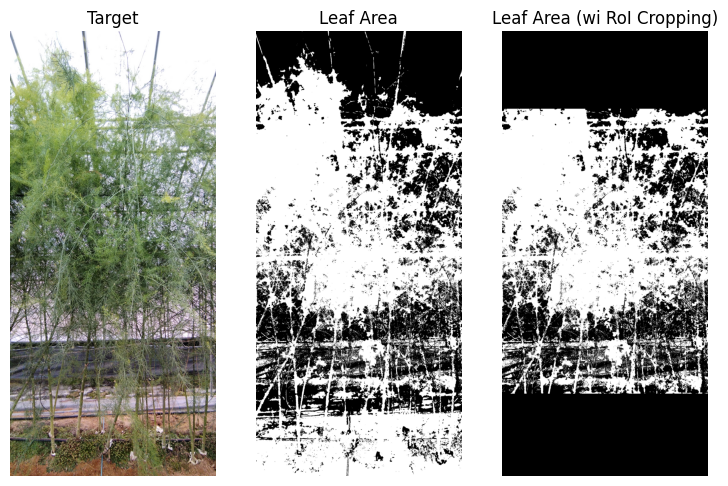

In [17]:
leaf_candidate_area_mask = 255 - (bright_area_mask & np.bitwise_not(green_area_mask))

leaf_candidate_area_mask_roi_h_truncated = np.zeros_like(leaf_candidate_area_mask)
leaf_candidate_area_mask_roi_h_truncated[hmin:hmax, :] = leaf_candidate_area_mask[hmin:hmax, :]
leaf_candidate_area_mask_roi_cropped = leaf_candidate_area_mask_roi_h_truncated[hmin:hmax, :]

leaf_candidate_area_mask_3ch = cv2.cvtColor(leaf_candidate_area_mask, cv2.COLOR_GRAY2BGR)
leaf_candidate_area_mask_roi_h_truncated_3ch = cv2.cvtColor(leaf_candidate_area_mask_roi_h_truncated, cv2.COLOR_GRAY2BGR)

draw_multiple_image(
    ["Target", "Leaf Area", "Leaf Area (wi RoI Cropping)"],
    [target_image, leaf_candidate_area_mask_3ch, leaf_candidate_area_mask_roi_h_truncated_3ch],
    figsize=(9, 16),
)

heatmap_img.shape: (2090, 1506, 3), target_image.shape: (3264, 1506, 3), 2090


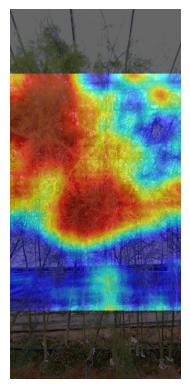

In [20]:
from scripts.leaf_density_index import normalize
from scripts.utils import alpha_blend

density_img = normalize(
    cv2.blur(leaf_candidate_area_mask_roi_cropped, (KERNEL_SIZE, KERNEL_SIZE)), v_min=DENSITY_MIN
)
heatmap_img = cv2.applyColorMap(density_img, cv2.COLORMAP_JET)
print(f"heatmap_img.shape: {heatmap_img.shape}, target_image.shape: {target_image.shape}, {hmax-hmin}")
overlay_heatmap = alpha_blend(target_image, heatmap_img, hmin, hmax)

show_image_from_ndarray(overlay_heatmap)

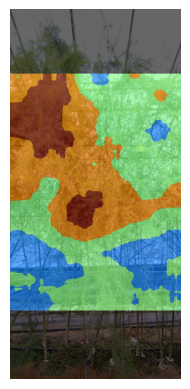

In [22]:
from scripts.leaf_density_index import discretize

# Visualization (contour)
contour_img = cv2.applyColorMap(discretize(density_img), cv2.COLORMAP_JET)
overlay_contour = alpha_blend(target_image, contour_img, hmin, hmax)

show_image_from_ndarray(overlay_contour)